In [72]:
def plot_decision(X, y, model):
    X_min, Y_min = X.min(axis=0)
    X_max, Y_max = X.max(axis=0)

    xx, yy = np.meshgrid(np.linspace(X_min - 1, X_max + 1, 100),
                         np.linspace(Y_min - 1, Y_max + 1, 100))

    ZZ = ada2.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.contourf(xx, yy, ZZ, alpha=.3, colors=["red", "green"])
    plt.scatter(X[y == -1, 0], X[y == -1, 1], marker='+', c='green', label='-1')
    plt.scatter(X[y == 1, 0], X[y == 1, 1], marker='o', c='red', label='1')
    plt.legend()

# Python Machine Learning - Chaper 02
https://www.amazon.com/Python-Machine-Learning-Sebastian-Raschka/dp/1783555130

plot_confusion_matrix
http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/
http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/
http://rasbt.github.io/mlxtend/user_guide/feature_selection/ExhaustiveFeatureSelector/
http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from mlxtend.plotting import plot_decision_regions

%matplotlib inline

# Perceptron

### adicionando x0 a X

In [4]:
X = np.random.random((2, 3))
X, np.c_[np.ones(X.shape[0]), X]

(array([[ 0.21840695,  0.97027476,  0.41162367],
        [ 0.31563571,  0.86309728,  0.04489299]]),
 array([[ 1.        ,  0.21840695,  0.97027476,  0.41162367],
        [ 1.        ,  0.31563571,  0.86309728,  0.04489299]]))

### inicializando w com valores aleatórios

In [5]:
seed = 10
random_state = np.random.RandomState(seed)

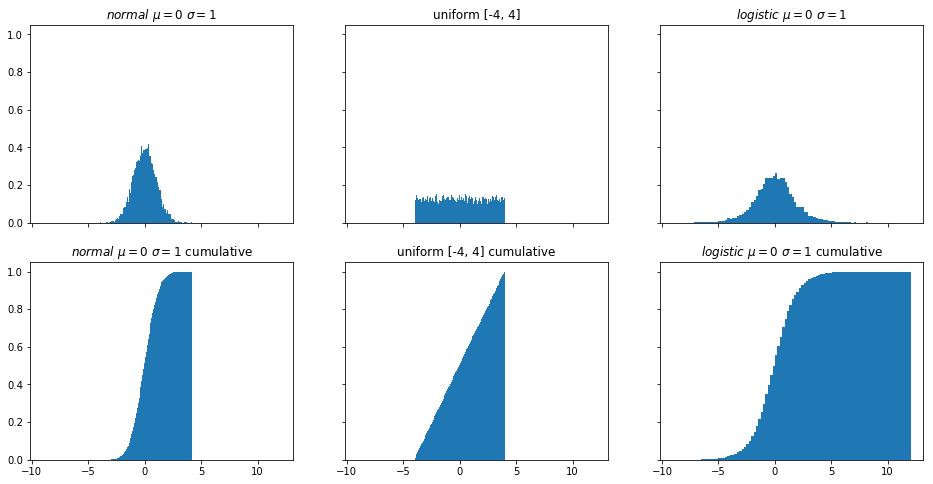

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=True, sharex=True)

samples = [
    ('$normal\ \mu = 0\ \sigma = 1$', random_state.normal(size=10000)),
    ('uniform [-4, 4]', random_state.uniform(-4, 4, size=10000)),
    ('$logistic\ \mu = 0\ \sigma = 1$', random_state.logistic(size=10000))
]

for i, (sample_desc, sample) in enumerate(samples):
    
    axes[0][i].hist(sample, bins=100, normed=True)
    axes[0][i].set_title(sample_desc)

    axes[1][i].hist(sample, bins=100, normed=True, cumulative=True)
    axes[1][i].set_title('%s cumulative' % sample_desc)

In [17]:
from sklearn.utils import check_random_state

class Perceptron(object):
    
    def __init__(self, eta=.01, n_iter=10, random_state=None):
        
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = check_random_state(random_state)
        
    def fit(self, X, y):
        
        # adding x0 
        # pensando melhor, adicionar x0 ao X ocupa espaço desnecessário...
        X = np.c_[np.ones(X.shape[0]), X]
        
        # initializing w
        if self.random_state:
            
            self.w_ = self.random_state.random_sample(X.shape[1])
        else:
            
            self.w_ = np.zeros(X.shape[1])

        self.errors_ = []
        
        for _ in range(self.n_iter):
            
            errors = 0
            for xi, target in zip(X, y):
                
                # update = learning_rate * (yi - yi')
                update = self.eta * (target - self.__predict(xi))
                # w[t+1] = w[t] + xi*update
                self.w_ += update * xi
                # errors += 1 if y != y'
                errors += int(update != 0.0)
            
            self.errors_.append(errors)
            
        return self
    
    def net_input(self, X):
        
        # X.w
        return np.dot(X, self.w_)
    
    def __predict(self, X):
        
        # 1 if X.w >= 0
        # -1 else
        return np.where(self.net_input(X) >= 0.0, 1, -1)
    
    def predict(self, X):
        
        # adding x0
        X = np.c_[np.ones(X.shape[0]), X]
        
        return self.__predict(X)

# Iris dataset

In [12]:
from sklearn.datasets import load_iris

In [13]:
iris = load_iris()

In [14]:
y = iris.target[:100]
y = np.where(y == 0, -1, 1)
X = iris.data[:100, [0, 2]]

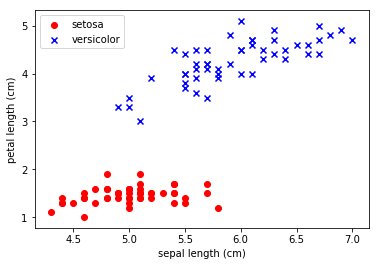

In [15]:
plt.scatter(X[:50, 0], X[:50, 1], color='r', marker='o', label='setosa')
plt.scatter(X[50:, 0], X[50:, 1], color='b', marker='x', label='versicolor')
plt.xlabel('sepal length (cm)')
plt.ylabel('petal length (cm)')
plt.legend(loc='upper left')

# Perceptron(iris)

### w = ones

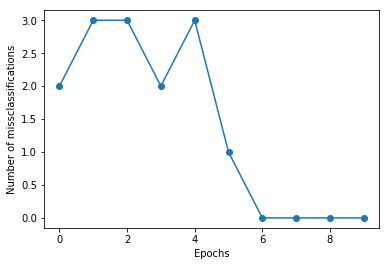

In [18]:
p_ones = Perceptron(eta=.1, n_iter=10)
p_ones.fit(X, y)

plt.plot(range(len(p_ones.errors_)), p_ones.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of missclassifications')

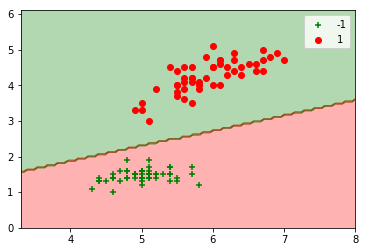

In [74]:
plot_decision(X, y, p_ones)

### w = random

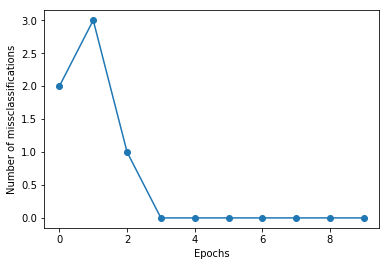

In [20]:
p_rand = Perceptron(eta=.1, n_iter=10, random_state=56)
p_rand.fit(X, y)

plt.plot(range(len(p_rand.errors_)), p_rand.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of missclassifications')

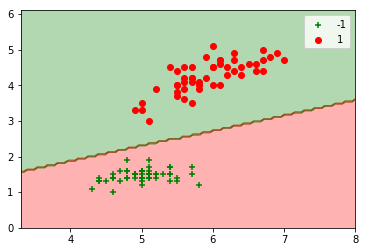

In [75]:
plot_decision(X, y, p_rand)

# AdalineGD

In [22]:
class AdalineGD(object):
    
    def __init__(self, eta=.01, n_iter=50):
        
        self.eta = eta
        self.n_iter = n_iter
            
    def fit(self, X, y):
        
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []
        
        for _ in range(self.n_iter):
            
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.
            self.cost_.append(cost)
        
        return self
    
    def net_input(self, X):
        
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        
        return self.net_input(X)
    
    def predict(self, X):
        
        return np.where(self.activation(X) >= .0, 1, -1)

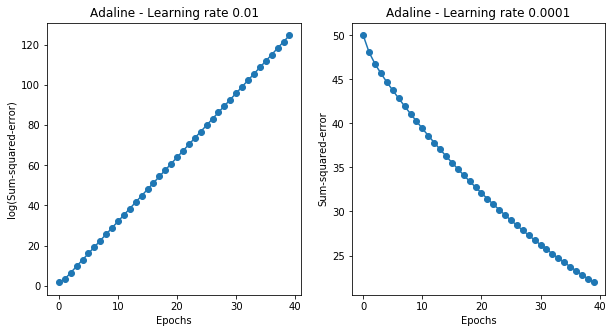

In [28]:
n_iter = 40
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ada1 = AdalineGD(n_iter=n_iter, eta=.01).fit(X, y)
ada2 = AdalineGD(n_iter=n_iter, eta=.0001).fit(X, y)

ax[0].plot(range(n_iter), np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adaline - Learning rate {}'.format(ada1.eta))

ax[1].plot(range(n_iter), ada2.cost_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Sum-squared-error')
ax[1].set_title('Adaline - Learning rate {}'.format(ada2.eta))

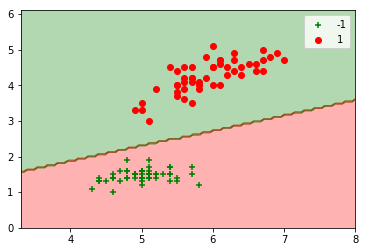

In [76]:
plot_decision(X, y, ada2)

## AdalineGD + standard scaling

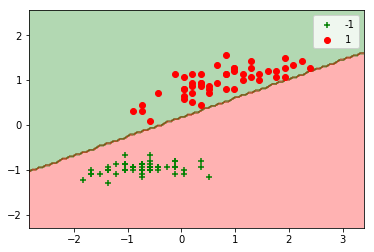

In [77]:
X_std = np.copy(X)

X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

ada = AdalineGD(n_iter = 15, eta = .01).fit(X_std, y)

plot_decision(X_std, y, ada)

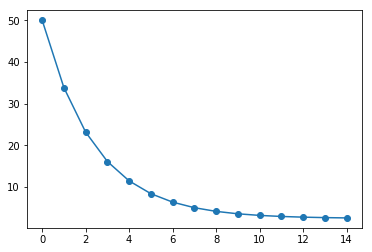

In [78]:
plt.plot(range(len(ada.cost_)), ada.cost_, marker='o')

# Stochastic AdalineGD

In [90]:
class AdalineSGD(object):
    
    def __init__(self, eta=.01, n_iter=10, shuffle=True, random_state=None):
        
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = check_random_state(random_state)
            
    def fit(self, X, y):

        self._initialize_weights(X.shape[1])
        self.cost_ = []
        
        n_samples = X.shape[0]

        for _ in range(self.n_iter):

            if self.shuffle:

                X, y = self._shuffle(X, y)

            cost = []
            for xi, target in zip(X, y):

                cost.append(self._update_weights(xi, target))

            avg_cost = sum(cost) / n_samples
            self.cost_.append(avg_cost)

        return self

    def partial_fit(self, X, y):

        if not self.w_initialized:

            self._initialize_weights(X.shape[1])

        if y.ravel().shape[0] > 1:

            for xi, target in zip(X, y):

                self._update_weights(xi, target)

        else:

            self._update_weights(X, y)

        return self

    def _shuffle(self, X, y):

        r = self.random_state.permutation(len(y))

        return X[r], y[r]

    def _initialize_weights(self, m):

        self.w_ = np.zeros(1 + m)
        self.w_initialized = True

    def _update_weights(self, xi, target):

        output = self.net_input(xi)
        error = (target - output)
        self.w_[1:] += self.eta * xi * error
        self.w_[0] += self.eta * error
        cost = .5 * error ** 2

        return cost

    def net_input(self, X):

        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):

        return self.net_input(X)

    def predict(self, X):

        return np.where(self.activation(X) >= .0, 1, -1)

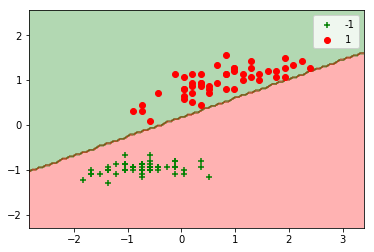

In [92]:
ada = AdalineSGD(n_iter = 15, eta = .01, random_state = 0).fit(X_std, y)

plot_decision(X_std, y, ada)

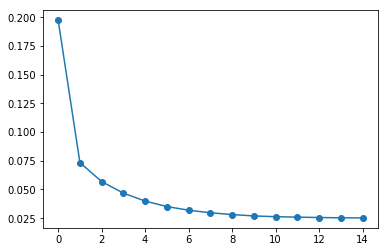

In [93]:
plt.plot(range(len(ada.cost_)), ada.cost_, marker='o')